## Energy-Aware Hybrid Execution with AMD Ryzen CPUs (Developer Test)

This experiment conducts the hybrid simulation to include **energy and cost modeling**
while replacing the generic CPU model with **AMD Ryzen–based CPUs**.

The objective is to validate that:
- Ryzen CPUs integrate cleanly into the hybrid execution path,
- CPU and QPU energy consumption is tracked consistently,
- cost attribution responds correctly to heterogeneous device power models.

---

### What is being tested
- End-to-end hybrid execution with **Ryzen CPU devices**
- Per-device power specification for CPUs and QPUs
- Affine CPU power model (idle → peak scaling with utilization)
- Correct aggregation of execution time → energy → monetary cost

---

### Configuration highlights
- Distinct power profiles for each QPU and CPU
- Electricity price applied uniformly across devices
- CPU energy modeled using an **affine utilization-based model**
- Larger workload trace (2000 jobs) to stress cost accounting paths

---


In [1]:
# main.py

from HybridCloud import *

PRINTLOG = False
# Devices
ibm_kawasaki = IBM_Kawasaki(env=None, name="QPU-1", printlog = PRINTLOG)
ibm_kyiv = IBM_Kyiv(env=None, name="QPU-2", printlog = PRINTLOG)
cpu1 = AMDRyzen("CPU-1", env=None)
cpu2 = AMDRyzen("CPU-2", env=None)
# cpu1 = CPU("CPU-1", env=None)
# cpu2 = CPU("CPU-2", env=None)

cost_config = {
  "energy": {
    "electricity_price_per_kwh": 0.18,
    "default_qpu_power_kw": 50.0,
    "qpu_power_kw": {"QPU-1": 70.0, "QPU-2": 60.0},
    "cpu_power_kw": {"CPU-1": 5.0, "CPU-2": 6.5},
    "cpu_power_model": "affine",
    "default_cpu_idle_kw": 0.22,
    "default_cpu_peak_kw": 0.75,
    "default_cpu_capacity_units": 16,
    "debug_energy": False
  }
}


# Hybrid environment
sim_env = HybridCloudSimEnv(
    qpu_devices = [ibm_kawasaki, ibm_kyiv],
    cpu_devices = [cpu1, cpu2],
    broker_class = HybridBroker,
    job_feed_method = 'dispatcher',
    file_path = 'synth_job_batches/10-job-2.csv', 
    job_generation_model = None, 
    printlog = PRINTLOG, 
    cost_config=cost_config
)


print(f"cpu_power_model: {sim_env.cost_config['energy']['cpu_power_model']}")
print(f"default_cpu_idle_kw: {sim_env.cost_config['energy']['default_cpu_idle_kw']}")

sim_env.run()

cpu_power_model: affine
default_cpu_idle_kw: 0.22
2 QPU(s), 2 CPU(s)
0.00: SIMULATION STARTED
59.55: SIMULATION ENDED
Number of jobs processed: 10


In [2]:
rec = sim_env.job_records_manager.get_job_records()
for i in range(0, 2): 
    print("Job: ", i)
    print("QPU time (s):", rec[i]["qpu_time_s"])
    print("CPU time (s):", rec[i]["cpu_time_s"])
    print("Energy (kWh):", rec[i]["energy_total_kwh"])
    print("Cost ($):", rec[i]["cost_energy_total"])
    print("")

Job:  0
QPU time (s): 27.4905
CPU time (s): 2.9786
Energy (kWh): 0.485
Cost ($): 0.0873

Job:  1
QPU time (s): 13.7049
CPU time (s): 1.9107
Energy (kWh): 0.2392
Cost ($): 0.043



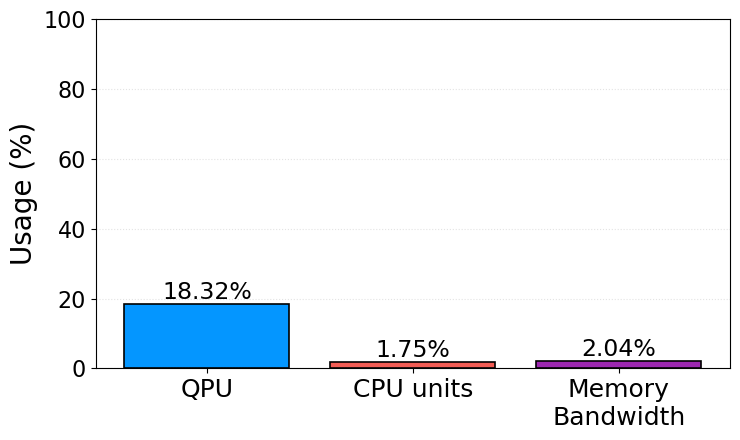

<Figure size 640x480 with 0 Axes>

In [3]:
results = calculate_device_usage_units(rec, sim_env)
plot_hybrid_utilization(results)
plt.savefig("results/new-usage.png", dpi=300, bbox_inches="tight")

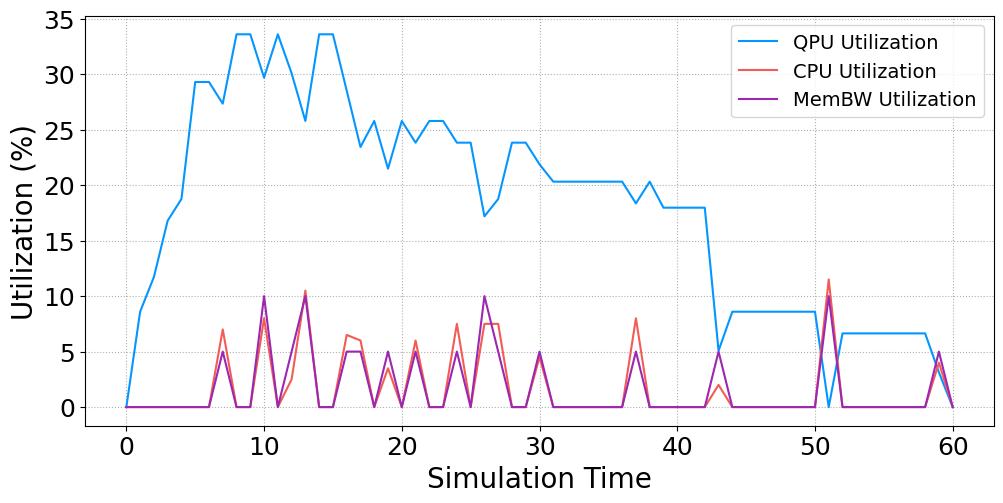

<Figure size 640x480 with 0 Axes>

In [4]:
time_points, qpu_util, cpu_util, mem_util = utilization_time_series(rec, 256, 200, 400, step = 1.0)
plot_utilization_over_time(time_points, qpu_util, cpu_util, mem_util)
plt.savefig("results/new_usage_timeline.png", dpi=300, bbox_inches="tight")

### 1) Energy–cost decomposition (QPU vs CPU share)

From the generated results, we visualize. 

- Stacked bar of mean energy split (QPU vs CPU)
- Histogram of cost/job
- Prints summary stats (mean/median/p95)


=== Energy/Cost Summary ===
                  jobs: 10
   mean_energy_qpu_kwh: 0.587160
   mean_energy_cpu_kwh: 0.003740
 mean_energy_total_kwh: 0.590940
     mean_cost_per_job: 0.106360
   median_cost_per_job: 0.110450
      p95_cost_per_job: 0.173140
          mean_phi_qpu: 0.992272
          mean_phi_cpu: 0.007606


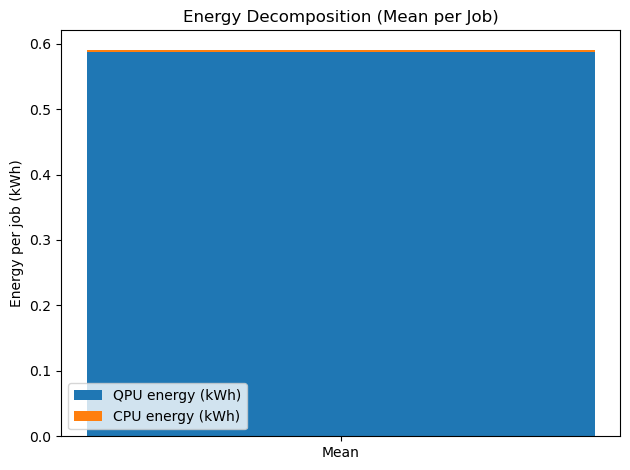

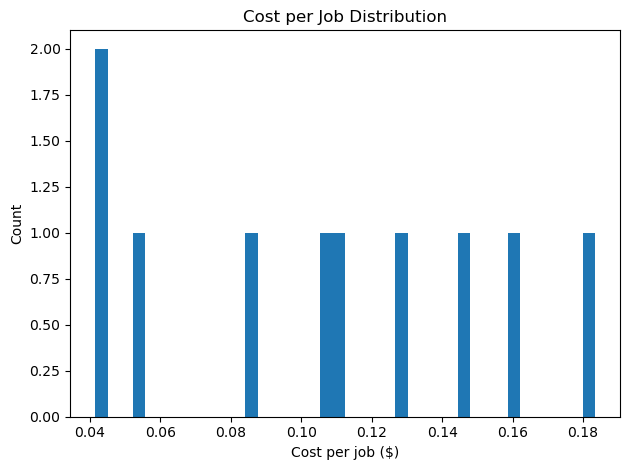

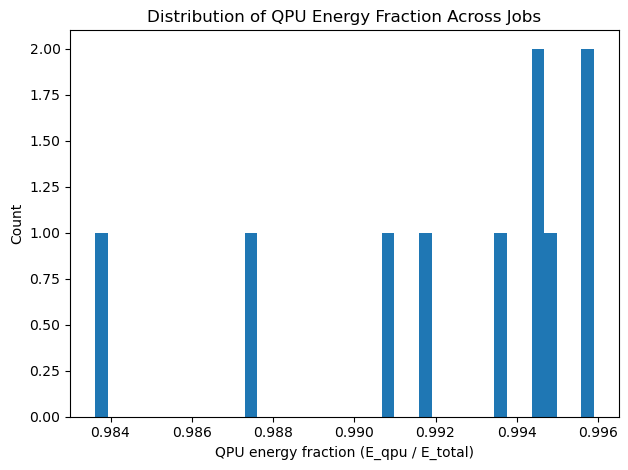

In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_job_energy_df(job_records: dict) -> pd.DataFrame:
    rows = []
    for job_id, rec in job_records.items():
        e_qpu = float(rec.get("energy_qpu_kwh", 0.0) or 0.0)
        e_cpu = float(rec.get("energy_cpu_kwh", 0.0) or 0.0)
        e_tot = float(rec.get("energy_total_kwh", e_qpu + e_cpu) or (e_qpu + e_cpu))
        c_tot = float(rec.get("cost_energy_total", 0.0) or 0.0)

        # Avoid divide-by-zero
        if e_tot > 0:
            phi_qpu = e_qpu / e_tot
            phi_cpu = e_cpu / e_tot
        else:
            phi_qpu = 0.0
            phi_cpu = 0.0

        rows.append({
            "job_id": job_id,
            "energy_qpu_kwh": e_qpu,
            "energy_cpu_kwh": e_cpu,
            "energy_total_kwh": e_tot,
            "cost_energy_total": c_tot,
            "phi_qpu": phi_qpu,
            "phi_cpu": phi_cpu,
            "qpu_time_s": float(rec.get("qpu_time_s", 0.0) or 0.0),
            "cpu_time_s": float(rec.get("cpu_time_s", 0.0) or 0.0),
        })

    df = pd.DataFrame(rows).sort_values("job_id").reset_index(drop=True)
    return df

def print_summary(df: pd.DataFrame):
    def p95(x):
        return float(np.percentile(x, 95))

    summary = {
        "jobs": len(df),
        "mean_energy_qpu_kwh": df["energy_qpu_kwh"].mean(),
        "mean_energy_cpu_kwh": df["energy_cpu_kwh"].mean(),
        "mean_energy_total_kwh": df["energy_total_kwh"].mean(),
        "mean_cost_per_job": df["cost_energy_total"].mean(),
        "median_cost_per_job": df["cost_energy_total"].median(),
        "p95_cost_per_job": p95(df["cost_energy_total"]),
        "mean_phi_qpu": df["phi_qpu"].mean(),
        "mean_phi_cpu": df["phi_cpu"].mean(),
    }

    print("\n=== Energy/Cost Summary ===")
    for k, v in summary.items():
        if isinstance(v, float):
            print(f"{k:>22}: {v:.6f}")
        else:
            print(f"{k:>22}: {v}")

def plot_energy_split(df: pd.DataFrame):
    # Mean energy split
    mean_qpu = df["energy_qpu_kwh"].mean()
    mean_cpu = df["energy_cpu_kwh"].mean()

    plt.figure()
    plt.bar(["Mean"], [mean_qpu], label="QPU energy (kWh)")
    plt.bar(["Mean"], [mean_cpu], bottom=[mean_qpu], label="CPU energy (kWh)")
    plt.ylabel("Energy per job (kWh)")
    plt.title("Energy Decomposition (Mean per Job)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cost_distribution(df: pd.DataFrame):
    plt.figure()
    plt.hist(df["cost_energy_total"], bins=40)
    plt.xlabel("Cost per job ($)")
    plt.ylabel("Count")
    plt.title("Cost per Job Distribution")
    plt.tight_layout()
    plt.show()

def plot_phi_distribution(df: pd.DataFrame):
    plt.figure()
    plt.hist(df["phi_qpu"], bins=40)
    plt.xlabel("QPU energy fraction (E_qpu / E_total)")
    plt.ylabel("Count")
    plt.title("Distribution of QPU Energy Fraction Across Jobs")
    plt.tight_layout()
    plt.show()

# ---- Run after sim_env.run() ----
job_records = sim_env.job_records_manager.job_records
df = build_job_energy_df(job_records)

print_summary(df)
plot_energy_split(df)
plot_cost_distribution(df)
plot_phi_distribution(df)

### 2) Sensitivity sweep on superconducting QPU baseline power (must-have)

This is a post-processing sensitivity sweep on the existing job records.

That gives us the same timing trace, and we just recompute:

$$
E_{\text{qpu}} = \sum_i P_{\text{qpu}} \cdot \frac{t_i}{3600}
\quad\Rightarrow\quad
\text{Cost} = (E_{\text{qpu}} + E_{\text{cpu}})\cdot \pi
$$

Below is code that:
- 1.	takes your job_records
- 2.	sweeps QPU baseline power
- 3.	computes avg cost/job (and p95) for each scenario
- 4.	plots the sensitivity curve

⸻

✅ Post-processing sensitivity sweep (recommended)

What it assumes
- You already ran sim_env.run()
- Your records contain either:
- qpu_time_s and/or qpu_segments with per-segment time_s
- CPU energy is already computed correctly (or we can keep CPU constant across sweeps)


QPU_kW, mean_cost, p95_cost, median_cost
    25, 0.041393, 0.068228, 0.042504
    50, 0.082112, 0.135633, 0.084360
    80, 0.130975, 0.216519, 0.134587
   100, 0.163551, 0.270443, 0.168072
   140, 0.228702, 0.378291, 0.235042


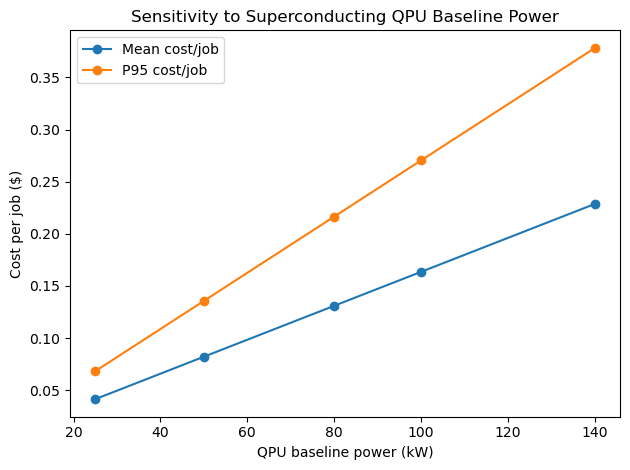

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def recompute_cost_for_qpu_power(job_records, qpu_power_kw, electricity_price_per_kwh=0.18):
    """
    Recompute per-job total cost under a *uniform* QPU baseline power (kW),
    keeping CPU energy as-is from the record.
    Returns list of per-job costs.
    """
    costs = []

    for job_id, rec in job_records.items():
        # CPU energy stays unchanged across QPU power sweep
        e_cpu = float(rec.get("energy_cpu_kwh", 0.0) or 0.0)

        # Compute QPU energy from segments if available; fallback to qpu_time_s
        if "qpu_segments" in rec and rec["qpu_segments"]:
            qpu_time_s_total = sum(float(seg.get("time_s", 0.0) or 0.0) for seg in rec["qpu_segments"])
        else:
            qpu_time_s_total = float(rec.get("qpu_time_s", 0.0) or 0.0)

        e_qpu = qpu_power_kw * (qpu_time_s_total / 3600.0)

        e_total = e_qpu + e_cpu
        cost = e_total * electricity_price_per_kwh
        costs.append(cost)

    return costs

def summarize(costs):
    costs = np.array(costs, dtype=float)
    return {
        "mean": float(costs.mean()),
        "median": float(np.median(costs)),
        "p95": float(np.percentile(costs, 95)),
    }

def sweep_qpu_power(job_records, powers_kw, electricity_price_per_kwh=0.18):
    results = []
    for p in powers_kw:
        costs = recompute_cost_for_qpu_power(job_records, p, electricity_price_per_kwh)
        s = summarize(costs)
        results.append((p, s["mean"], s["p95"], s["median"]))
    return results

def plot_sweep(results):
    powers = [r[0] for r in results]
    means  = [r[1] for r in results]
    p95s   = [r[2] for r in results]

    plt.figure()
    plt.plot(powers, means, marker="o", label="Mean cost/job")
    plt.plot(powers, p95s, marker="o", label="P95 cost/job")
    plt.xlabel("QPU baseline power (kW)")
    plt.ylabel("Cost per job ($)")
    plt.title("Sensitivity to Superconducting QPU Baseline Power")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Run after sim_env.run() ----
job_records = sim_env.job_records_manager.job_records

powers_kw = [25, 50, 80, 100, 140]  # choose your sweep set
results = sweep_qpu_power(job_records, powers_kw, electricity_price_per_kwh=0.18)

print("QPU_kW, mean_cost, p95_cost, median_cost")
for p, mean_c, p95_c, med_c in results:
    print(f"{p:>6}, {mean_c:.6f}, {p95_c:.6f}, {med_c:.6f}")

plot_sweep(results)

If you want device-specific power sweep (QPU-1 and QPU-2 differ)

Sometimes reviewers like a sweep that preserves relative device differences.

Example: keep ratios (70:60) but scale them together:

In [7]:
def recompute_cost_with_scaled_qpu_map(job_records, base_map_kw, scale, electricity_price_per_kwh=0.18):
    costs = []
    for job_id, rec in job_records.items():
        e_cpu = float(rec.get("energy_cpu_kwh", 0.0) or 0.0)
        e_qpu = 0.0

        # qpu_segments contain device + time_s
        for seg in rec.get("qpu_segments", []):
            dev = seg.get("device")
            t_s = float(seg.get("time_s", 0.0) or 0.0)
            p_kw = base_map_kw.get(dev, 0.0) * scale
            e_qpu += p_kw * (t_s / 3600.0)

        cost = (e_qpu + e_cpu) * electricity_price_per_kwh
        costs.append(cost)
    return costs

Then sweep scale instead of raw kW.

When you do need to rerun the simulator

Only rerun if:
	•	your scheduler/broker will choose devices based on energy/cost, or
	•	power model influences runtime (it currently doesn’t).

For this paper’s Experiment 2, post-processing is the right approach.

⸻

What to report in the manuscript

For each power setting:
	•	mean cost/job
	•	p95 cost/job
	•	(optional) mean energy/job (kWh)

And one figure:
	•	line plot: QPU baseline power (kW) → mean cost/job

⸻

If you paste a snippet of one record’s qpu_segments after your CPU fix (just to confirm the keys), I’ll tailor the sweep code to exactly match your structure (but the above should work with what you showed).